In [15]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-adjust/adjusted_stock_1301.csv
/kaggle/input/new-adjust/adjusted_stock_1332.csv
/kaggle/input/notchanged/stock_1332.csv
/kaggle/input/notchanged/stock_1301.csv
/kaggle/input/stock/Netflix.csv
/kaggle/input/stock/Microsoft.csv
/kaggle/input/stock/Google.csv
/kaggle/input/stock/Amazon.csv
/kaggle/input/stock/Apple.csv
/kaggle/input/mydatata/final_modified_stock_prices.csv
/kaggle/input/new-1301-and-1332/combined_1301.csv
/kaggle/input/new-1301-and-1332/combined_1332.csv
/kaggle/input/1301and1332/stock_1332.csv
/kaggle/input/1301and1332/stock_1301.csv
/kaggle/input/secondhahaah/modified_secondary_stock_prices.csv
/kaggle/input/training/modified_stock_1301.csv
/kaggle/input/training/modified_stock_1332.csv


In [16]:
# Reference: https://github.com/ctxj/Time-Series-Transformer-Pytorch/tree/main
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import math
import time
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [17]:
Fprice_df = pd.read_csv("/kaggle/input/notchanged/stock_1301.csv")
Sprice_df = pd.read_csv("/kaggle/input/notchanged/stock_1332.csv")

In [18]:
stock_df = dict()
stock_df['FIRSTPRICE'] = Fprice_df
stock_df['SECONDPRICE'] = Sprice_df


In [19]:
def calculate_features(df):
    # Create new features based on the original features of the dataframe
    df['Daily_Return'] = df['Close'].pct_change()
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['Volatility_20'] = df['Close'].rolling(window=20).std()

    # Calculate Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_prevclose = (df['High'] - df['Close'].shift()).abs()
    low_prevclose = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.DataFrame({'High-Low': high_low, 'High-PrevClose': high_prevclose, 'Low-PrevClose': low_prevclose}).max(axis=1)
    df['ATR'] = tr.rolling(window=14).mean()

    return df

# Calculate features for both Fprice_df and Sprice_df
calculate_features(Fprice_df)
calculate_features(Sprice_df)

/tmp/ipykernel_34/3306236246.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Close'].pct_change()
/tmp/ipykernel_34/3306236246.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Close'].pct_change()


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Daily_Return,MA_5,MA_20,Volatility_20,ATR
0,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,NaN,NaN,NaN,NaN,NaN
1,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609,-0.005254,NaN,NaN,NaN,NaN
2,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014,0.012324,NaN,NaN,NaN,NaN
3,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275,-0.022609,NaN,NaN,NaN,NaN
4,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544,-0.016014,565.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,20211129_1332,2021-11-29,1332,579.0,579.0,567.0,567.0,1607200,1.0,NaN,False,0.001745,-0.030769,588.0,616.35,25.637709,11.500000
1198,20211130_1332,2021-11-30,1332,580.0,590.0,573.0,573.0,2732300,1.0,NaN,False,-0.001742,0.010582,582.4,612.65,26.312445,12.142857
1199,20211201_1332,2021-12-01,1332,568.0,578.0,568.0,574.0,1661300,1.0,NaN,False,0.020942,0.001745,578.4,608.40,25.276159,12.071429
1200,20211202_1332,2021-12-02,1332,566.0,577.0,565.0,573.0,1525800,1.0,NaN,False,0.006838,-0.001742,574.4,604.60,24.553701,12.428571


In [20]:
features = ['Open', 'High', 'Low', 'Close', 'Volume','Daily_Return','MA_5','MA_20','Volatility_20','ATR']

In [21]:
selected_features = stock_df['FIRSTPRICE'][features]

In [22]:
for feature in features:
     positive_values = selected_features[feature] > 0
    # Compute the log of the prices to get the log returns
     log_prices = np.diff(np.log(selected_features[feature][positive_values]))

    # Compute the cumulative sum of the log returns
     log_prices_csum = np.cumsum(log_prices)

In [47]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

df = pd.read_csv('/kaggle/input/notchanged/stock_1301.csv') # data path of facebook stock price (Apr 2019 - Nov 2020)
close = np.array(df['Close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

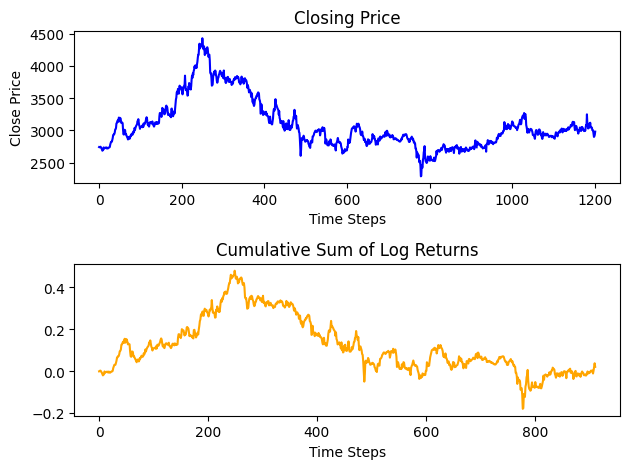

In [48]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='blue')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='orange')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

In [25]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
input_window = 7 # number of input time steps
output_window = 1 # number of prediction steps (equals to one)
batch_size = 1

In [26]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:x.size(0), :])

In [27]:
class Transformer(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, dropout=0.1):
        # feautre_size equals to embedding dimension (d_model)
        super().__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        
        # Apply nhead multi-head attention
        # d_key, d_query, d_value = d_model // n_head
        self.encoder_layer = TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        
        # Use num_layers encoders
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # For simple time-series prediction, decoder just uses FC layer
        self.decoder = nn.Linear(feature_size, 1)
        self._init_weights()

    def _init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1) # Lower Triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

In [28]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [29]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [30]:
train_data, test_data = get_data(log_prices, 0.7) # 70% for train and 30% for test

/tmp/ipykernel_34/1471902572.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(inout_seq)


In [31]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [32]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss = total_loss + loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [33]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [34]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [35]:
model = Transformer().to(device)

criterion = nn.MSELoss() 
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

N_EPOCHS = 150

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [36]:
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_data)

    if (epoch % N_EPOCHS == 0):  # Valid model after last training epoch
        val_loss = evaluate(model, test_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                   (time.time() - epoch_start_time),
                                                                                   val_loss))
        print('-' * 80)

    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |   162/  814 batches | lr 0.0000500000 |  9.28 ms | loss 0.1378146
| epoch   1 |   324/  814 batches | lr 0.0000500000 |  5.86 ms | loss 0.1997789
| epoch   1 |   486/  814 batches | lr 0.0000500000 |  5.58 ms | loss 0.1871234
| epoch   1 |   648/  814 batches | lr 0.0000500000 |  5.69 ms | loss 0.2423852
| epoch   1 |   810/  814 batches | lr 0.0000500000 |  5.75 ms | loss 0.4376289
--------------------------------------------------------------------------------
| end of epoch   1 | time:  5.22s
--------------------------------------------------------------------------------
| epoch   2 |   162/  814 batches | lr 0.0000451250 |  5.77 ms | loss 0.4709585
| epoch   2 |   324/  814 batches | lr 0.0000451250 |  5.75 ms | loss 0.1465627
| epoch   2 |   486/  814 batches | lr 0.0000451250 |  5.63 ms | loss 0.1387629
| epoch   2 |   648/  814 batches | lr 0.0000451250 |  5.73 ms | loss 0.4075800
| epoch   2 |   810/  814 batches | lr 0.0000451250 |  5.51 ms | loss 0.5438530
----

In [37]:
predicted_seq, real_seq = predict(model, test_data)

0.532463788986206 sec


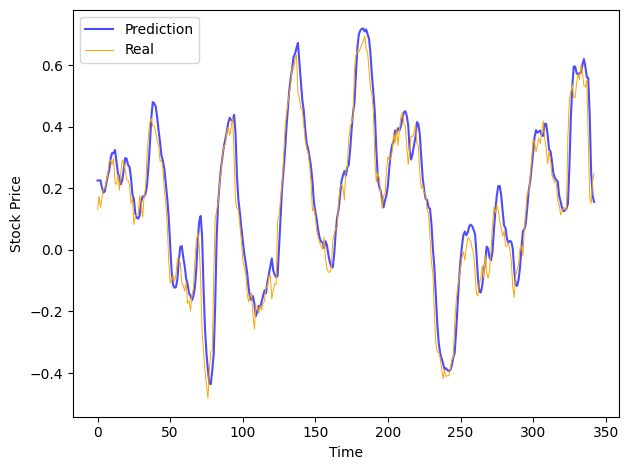

In [50]:
fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq, color='blue', alpha=0.7)
ax2.plot(real_seq, color='orange', linewidth=0.7)
ax2.legend(['Prediction', 'Real'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Stock Price')

fig2.tight_layout()

In [39]:
selected_features_df = stock_df['SECONDPRICE'][features]

In [40]:
#close_msft = stock_df['SECONDPRICE'].Close
for feature in features:
    positive_values = selected_features_df[feature] > 0
    log_prices2 = np.diff(np.log(selected_features_df[feature][positive_values]))

In [41]:
train_data2, test_data2 = get_data(log_prices2, 0.7)

In [42]:
predicted_seq2, real_seq2 = predict(model, test_data2)

0.5752291679382324 sec


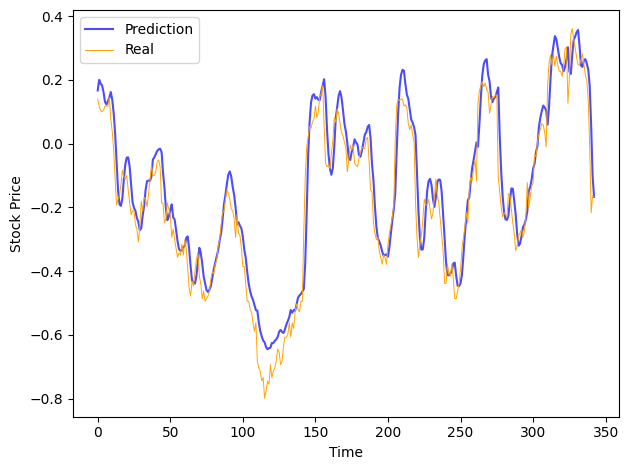

In [49]:
fig3, ax3 = plt.subplots(1, 1)

ax3.plot(predicted_seq2, color='blue', alpha=0.7)
ax3.plot(real_seq2, color='orange', linewidth=0.7)
ax3.legend(['Prediction', 'Real'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Stock Price')

fig3.tight_layout()